# Project 02 - Image Processing

## Thông tin sinh viên

- Họ và tên: Nguyễn Thọ Tài
- MSSV: 23127255
- Lớp: 23CLC02

## Import các thư viện liên quan

In [1]:
!python -m pip install matplotlib
!python -m pip install numpy
!python -m pip install Pillow

from PIL import Image # for read, write image
import numpy as np # for matrix compute
import matplotlib.pyplot as plt # for show image
import colorsys # for convert RGB to HSL

## Helper functions

In [2]:
# Any optional parameters beyond the required ones should be defined with default values
def read_img(img_path):
	""" Read image from img_path
	returns a 2D image (numpy array)
	"""
	return np.array(Image.open(img_path))

def show_img(img_2d):
	""" Show image
	"""
	plt.imshow(img_2d)
	plt.axis('off')
	plt.show()

def save_img(img_2d, img_path: str):
	"""	Save image to img_path
	"""
	Image.fromarray(img_2d).save(img_path)

def convert_rgb_to_hsl(img_2d):
	""" Convert RGB image to HSL image
	returns a 2D image (numpy array)
	"""
	norm_img = np.array(img_2d) / 255.0
	rgb2hsl_vec = np.vectorize(colorsys.rgb_to_hls)
	h, l, s = rgb2hsl_vec(norm_img[..., 0], norm_img[..., 1], norm_img[..., 2]) # img[..., 0] means take all previous dim but only the 0 index of the last one. (4, 4, 3) -> (4, 3)
	return np.stack([h, s, l], axis=-1)

def convert_hsl_to_rgb(img_2d):
	""" Convert HSL image to RGB image
	returns a 2D image (numpy array)
	"""
	hsl2rgb_vec = np.vectorize(colorsys.hls_to_rgb)
	r, g, b = hsl2rgb_vec(img_2d[..., 0], img_2d[..., 1], img_2d[..., 2])
	return Image.fromarray((np.stack([r, g, b], axis=-1) * 255).astype(np.uint8))

def img_change_brightness(img_2d, value):
	img_2d = img_2d.astype(np.float32)
	img_2d[..., :3] += value # only add value to the first 3 channels (R, G, B)
	return np.clip(img_2d, 0, 255).astype(np.uint8)

def img_change_contrast(img_2d, value):
	pass

def img_flip_horizontal(img_2d):
	return img_2d[:, ::-1]

def img_flip_vertical(img_2d):
	return img_2d[::-1, :]

def img_flip_horizontal_vertical(img_2d):
	return img_2d[::-1, ::-1]

def img_crop(img_2d, start: list[int], end: list[int]):
	height, width, _ = img_2d.shape
	x1, x2 = sorted([max(0, min(start[0], width)), max(0, min(end[0], width))])
	y1, y2 = sorted([max(0, min(start[1], height)), max(0, min(end[1], height))])

	return img_2d[y1:y2, x1:x2, :]

def img_crop_quarter_center(img_2d):
	height, width, _ = img_2d.shape
	start_height, start_width = height // 4, width // 4
	return img_crop(img_2d, [start_width, start_height], [start_width * 3, start_height * 3])

def blank_mask(img_2d):
	h, w, c = img_2d.shape
	masked_image = np.zeros_like(img_2d)
	if c == 4: # if RGBA image, set the mask to full opaque (img_2d.max() -> 1.0 or 255)
		masked_image[..., 3] = img_2d.max()
	return masked_image

def img_circle_mask(img_2d):
	height, width, _ = img_2d.shape
	Y, X = np.mgrid[0:height, 0:width]
	cx, cy = width // 2, height // 2
	r = min(cx, cx)

	mask = (X - cx) ** 2 + (Y - cy) ** 2 <= r ** 2
	masked_img = blank_mask(img_2d)
	masked_img[mask] = img_2d[mask]
	return masked_img

def rotated_ellipse_mask(x, y, a, b, theta):
	cos_t, sin_t = np.cos(theta), np.sin(theta)
	term1 = ((x * cos_t + y * sin_t) ** 2) / a ** 2
	term2 = ((x * sin_t - y * cos_t) ** 2) / b ** 2
	return (term1 + term2) <= 1 # x^2 / a^2 + y^2 / b^2 <= 1, take the inner part

def img_2ellipse_mask(img_2d: np.ndarray):
	height, width, _ = img_2d.shape
	Y, X = np.ogrid[:height, :width]
	diag = (width * width + height * height) ** 0.5 - 5

	a, b = 0.875 * diag / 2, 0.5 * diag / 2
	theta = np.deg2rad(45)

	# translate the grid coord to the center
	x = X - width // 2
	y = Y - height // 2

	frame_mask = np.logical_or(rotated_ellipse_mask(x, y, a, b, theta),
							   rotated_ellipse_mask(x, y, a, b, -theta))

	masked_img = blank_mask(img_2d)
	masked_img[frame_mask] = img_2d[frame_mask]
	return masked_img

def gen_box_blur(size: int) -> np.ndarray:
	return np.ones((size, size)) / size ** 2

MAT_BOX_BLUR_3 = gen_box_blur(3)
MAT_BOX_BLUR_5 = gen_box_blur(5)
MAT_BOX_BLUR_7 = gen_box_blur(7)
MAT_BOX_BLUR_15 = gen_box_blur(15)

MAT_GAUSS_BLUR_3 = 0.0625 * np.array(
	[[1, 2, 1],
	 [2, 4, 2],
	 [1, 2, 1]])
MAT_GAUSS_BLUR_5 = 0.00390625 * np.array(
	[[1,  4,  6,  4,  1],
	 [4, 16, 24, 16, 14],
	 [6, 24, 36, 24,  6],
	 [4, 16, 24, 16,  4],
	 [1,  4,  6,  4,  1]])

def gen_gauss_blur(size: int) -> np.ndarray:
    if size % 2 == 0 or size < 1:
        raise ValueError("Size must be odd and positive")
    kernel_1d = np.array([1, 1])
    for _ in range(size - 2):
        kernel_1d = np.convolve(kernel_1d, [1, 1])
    return np.outer(kernel_1d, kernel_1d) / np.sum(kernel_1d)**2

MAT_GAUSS_BLUR_7 = gen_gauss_blur(7)
MAT_GAUSS_BLUR_15 = gen_gauss_blur(15)
MAT_GAUSS_BLUR_21 = gen_gauss_blur(21)

MAT_UNSHARP_BLUR_5 = -0.00390625 * np.array(
	[[1,  4,    6,  4,  1],
	 [4, 16,   24, 16, 14],
	 [6, 24, -476, 24,  6],
	 [4, 16,   24, 16,  4],
	 [1,  4,    6,  4,  1]])

def kernel_convolution(img_2d: np.ndarray, kernel: np.ndarray) -> np.ndarray:
	if kernel.ndim != 2:
		raise ValueError('Input kernel must be 2D')
	if img_2d.ndim != 3:
		raise ValueError('Input image must be 3D')

	norm_img = img_2d.astype(np.float16) / 255.0
	height, width, _ = norm_img.shape
	k_height, k_width = kernel.shape
	if k_height != k_width:
		raise ValueError('Input kernel matrix must be square')

	# pad image to handle boundaries
	pad_size = k_height // 2
	pad_img = np.pad(norm_img, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant')
	# print(pad_img.size)

	patches = np.lib.stride_tricks.sliding_window_view(pad_img, window_shape=(k_height, k_height), axis=(0, 1)) # shape: (height, width, channel, k_height, k_width)
	result = np.einsum('abcde,de->abc', patches, kernel)
	result = np.clip(result * 255, 0, 255).astype(np.uint8)
	return result


def process_image(img_2d, func=[1, 2, 3,...]):
	""" Process image with a list of functions
	func: a list of functions to apply to the image
	return processed 2D image
	"""










## Your tests

In [3]:
import os
import tracemalloc
import time
import sys

def test_flip():
	os.makedirs("image/flip/", exist_ok=True)
	img = read_img("demo.png")
	flip_h_img = img_flip_horizontal(img)
	flip_v_img = img_flip_vertical(img)
	flip_hv_img = img_flip_horizontal_vertical(img)
	save_img(flip_h_img, "image/flip/flip_horizontal_demo.png")
	save_img(flip_v_img, "image/flip/flip_vertical_demo.png")
	save_img(flip_hv_img, "image/flip/flip_horizontal_vertical_demo.png")

def test_mask():
	os.makedirs("image/mask/", exist_ok=True)
	img = read_img("cat.jpg")
	circle_masked_img = img_circle_mask(img)
	ellipse_masked_img = img_2ellipse_mask(img)
	save_img(circle_masked_img, "image/mask/mask_circle_cat.png")
	save_img(ellipse_masked_img, "image/mask/mask_ellipse_cat.png")

orig_stdout = sys.stdout
def file_stdout(file: str):
	sys.stdout = open(file, 'w')

def reset_stdout():
	sys.stdout.close()
	sys.stdout = orig_stdout

In [4]:
def test_kernel_convolution_raw():
	img = np.array([
		[[1, 2, 3], [4, 5, 6], [7, 8, 9]],
		[[10, 11, 12], [13, 14, 15], [16, 17, 18]],
		[[19, 20, 21], [22, 23, 24], [25, 26, 27]]
	], dtype=np.uint8)

	kernel_3x3 = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=np.float32)
	result_3x3 = kernel_convolution(img, kernel_3x3)
	print(f"Result: \n{result_3x3}\n")

def benchmark_kernel_convolution(name: str, img_2d: np.ndarray, kernel: np.ndarray):
	tracemalloc.start()
	start_time = time.perf_counter()
	result = kernel_convolution(img_2d, kernel)
	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	current, peak = tracemalloc.get_traced_memory()
	tracemalloc.stop()
	print(f"Kernel: {name}")
	print(f"- Execution time: {elapsed_time:.6f} seconds")
	print(f"- Current memory usage: {current / 10**6:.2f} MB")
	print(f"- Peak memory usage: {peak / 10**6:.2f} MB")
	return result

def test_kernel_convolution():
	os.makedirs("image/kernel/", exist_ok=True)
	img = read_img("cat.jpg")
	start_time = time.perf_counter()

	box_blur_3_img = benchmark_kernel_convolution('box_blur_3', img, MAT_BOX_BLUR_3)
	box_blur_7_img = benchmark_kernel_convolution('box_blur_7', img, MAT_BOX_BLUR_7)
	box_blur_15_img = benchmark_kernel_convolution('box_blur_15', img, MAT_BOX_BLUR_15)

	gauss_blur_3_img = benchmark_kernel_convolution('gauss_blur_3', img, MAT_GAUSS_BLUR_3)
	gauss_blur_5_img = benchmark_kernel_convolution('gauss_blur_5', img, MAT_GAUSS_BLUR_5)
	gauss_blur_7_img = benchmark_kernel_convolution('gauss_blur_7', img, MAT_GAUSS_BLUR_7)
	gauss_blur_15_img = benchmark_kernel_convolution('gauss_blur_15', img, MAT_GAUSS_BLUR_15)
	gauss_blur_21_img = benchmark_kernel_convolution('gauss_blur_21', img, MAT_GAUSS_BLUR_21)

	unsharp_blur_img = benchmark_kernel_convolution('unsharp_blur', img, MAT_UNSHARP_BLUR_5)

	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	print(f"--------------- End in: {elapsed_time:.6f} seconds")

	save_img(box_blur_3_img, "image/kernel/box_blur_3_cat.png")
	save_img(box_blur_7_img, "image/kernel/box_blur_7_cat.png")
	save_img(box_blur_15_img, "image/kernel/box_blur_15_cat.png")

	save_img(gauss_blur_3_img, "image/kernel/gauss_blur_3_cat.png")
	save_img(gauss_blur_5_img, "image/kernel/gauss_blur_5_cat.png")
	save_img(gauss_blur_7_img, "image/kernel/gauss_blur_7_cat.png")
	save_img(gauss_blur_15_img, "image/kernel/gauss_blur_15_cat.png")
	save_img(gauss_blur_21_img, "image/kernel/gauss_blur_21_cat.png")

	save_img(unsharp_blur_img, "image/kernel/unsharp_blur_cat.png")
file_stdout("output/bench_normal.txt")
test_kernel_convolution()
reset_stdout()

## Main FUNCTION

Tile 1

In [5]:
def tiled_kernel_convolution_t1(img_2d: np.ndarray, kernel: np.ndarray, tile_size: int = 256) -> np.ndarray:
	if kernel.ndim != 2:
		raise ValueError('Input kernel must be 2D')
	if img_2d.ndim != 3:
		raise ValueError('Input image must be 3D')
	if kernel.shape[0] != kernel.shape[1]:
		raise ValueError('Input kernel matrix must be square')

	norm_img = img_2d.astype(np.float32) / 255.0  # Stick with float32 for accuracy
	height, width, channels = norm_img.shape
	k_height = kernel.shape[0]
	pad_size = k_height // 2
	pad_img = np.pad(norm_img, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant')
	result = np.zeros_like(norm_img)
	pad_tile_size = tile_size + 2 * pad_size
	# com_kernel = kernel[None, None, None, :, :]
	for i in range(0, height, tile_size):
		for j in range(0, width, tile_size):
			i_end = min(i + pad_tile_size, pad_img.shape[0])
			j_end = min(j + pad_tile_size, pad_img.shape[1])
			tile = pad_img[i:i_end, j:j_end]
			tile_patches = np.lib.stride_tricks.sliding_window_view(tile, window_shape=(k_height, k_height), axis=(0, 1))
			# tile_result = np.sum(tile_patches * com_kernel, axis=(3, 4))
			# Rewrite of the above hadamard product of tile_patches and kernel using einsum: https://stackoverflow.com/a/33641428
			# This help with performance and don't create a temp large ndarray causing bottleneck
			tile_result = np.einsum('abcde,de->abc', tile_patches, kernel)
			result[i:min(i + tile_size, height), j:min(j + tile_size, width)] = tile_result[:min(tile_size, height - i), :min(tile_size, width - j)]

	return np.clip(result * 255, 0, 255).astype(np.uint8)

In [6]:
def benchmark_kernel_convolution_t1(name: str, img_2d: np.ndarray, kernel: np.ndarray):
	tracemalloc.start()
	start_time = time.perf_counter()
	result = tiled_kernel_convolution_t1(img_2d, kernel)
	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	current, peak = tracemalloc.get_traced_memory()
	tracemalloc.stop()
	print(f"Kernel: {name}")
	print(f"- Execution time: {elapsed_time:.6f} seconds")
	print(f"- Current memory usage: {current / 10**6:.2f} MB")
	print(f"- Peak memory usage: {peak / 10**6:.2f} MB")
	return result

def test_kernel_convolution_t1():
	os.makedirs("image/kernel_t1/", exist_ok=True)
	img = read_img("cat.jpg")
	start_time = time.perf_counter()

	box_blur_3_img = benchmark_kernel_convolution_t1('box_blur_3', img, MAT_BOX_BLUR_3)
	box_blur_7_img = benchmark_kernel_convolution_t1('box_blur_7', img, MAT_BOX_BLUR_7)
	box_blur_15_img = benchmark_kernel_convolution_t1('box_blur_15', img, MAT_BOX_BLUR_15)

	gauss_blur_3_img = benchmark_kernel_convolution_t1('gauss_blur_3', img, MAT_GAUSS_BLUR_3)
	gauss_blur_5_img = benchmark_kernel_convolution_t1('gauss_blur_5', img, MAT_GAUSS_BLUR_5)
	gauss_blur_7_img = benchmark_kernel_convolution_t1('gauss_blur_7', img, MAT_GAUSS_BLUR_7)
	gauss_blur_15_img = benchmark_kernel_convolution_t1('gauss_blur_15', img, MAT_GAUSS_BLUR_15)
	gauss_blur_21_img = benchmark_kernel_convolution_t1('gauss_blur_21', img, MAT_GAUSS_BLUR_21)

	unsharp_blur_img = benchmark_kernel_convolution_t1('unsharp_blur', img, MAT_UNSHARP_BLUR_5)

	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	print(f"--------------- End in: {elapsed_time:.6f} seconds")

	save_img(box_blur_3_img, "image/kernel_t1/box_blur_3_cat.png")
	save_img(box_blur_7_img, "image/kernel_t1/box_blur_7_cat.png")
	save_img(box_blur_15_img, "image/kernel_t1/box_blur_15_cat.png")

	save_img(gauss_blur_3_img, "image/kernel_t1/gauss_blur_3_cat.png")
	save_img(gauss_blur_5_img, "image/kernel_t1/gauss_blur_5_cat.png")
	save_img(gauss_blur_7_img, "image/kernel_t1/gauss_blur_7_cat.png")
	save_img(gauss_blur_15_img, "image/kernel_t1/gauss_blur_15_cat.png")
	save_img(gauss_blur_21_img, "image/kernel_t1/gauss_blur_21_cat.png")

	save_img(unsharp_blur_img, "image/kernel_t1/unsharp_blur_cat.png")
file_stdout("output/bench_tiled_t1_256.txt")
test_kernel_convolution_t1()
reset_stdout()

In [7]:
def benchmark_kernel_convolution_t1_512(name: str, img_2d: np.ndarray, kernel: np.ndarray):
	tracemalloc.start()
	start_time = time.perf_counter()
	result = tiled_kernel_convolution_t1(img_2d, kernel, 512)
	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	current, peak = tracemalloc.get_traced_memory()
	tracemalloc.stop()
	print(f"Kernel: {name}")
	print(f"- Execution time: {elapsed_time:.6f} seconds")
	print(f"- Current memory usage: {current / 10**6:.2f} MB")
	print(f"- Peak memory usage: {peak / 10**6:.2f} MB")
	return result

def test_kernel_convolution_t1_512():
	os.makedirs("image/kernel_t1_512/", exist_ok=True)
	img = read_img("cat.jpg")
	start_time = time.perf_counter()

	box_blur_3_img = benchmark_kernel_convolution_t1_512('box_blur_3', img, MAT_BOX_BLUR_3)
	box_blur_7_img = benchmark_kernel_convolution_t1_512('box_blur_7', img, MAT_BOX_BLUR_7)
	box_blur_15_img = benchmark_kernel_convolution_t1_512('box_blur_15', img, MAT_BOX_BLUR_15)

	gauss_blur_3_img = benchmark_kernel_convolution_t1_512('gauss_blur_3', img, MAT_GAUSS_BLUR_3)
	gauss_blur_5_img = benchmark_kernel_convolution_t1_512('gauss_blur_5', img, MAT_GAUSS_BLUR_5)
	gauss_blur_7_img = benchmark_kernel_convolution_t1_512('gauss_blur_7', img, MAT_GAUSS_BLUR_7)
	gauss_blur_15_img = benchmark_kernel_convolution_t1_512('gauss_blur_15', img, MAT_GAUSS_BLUR_15)
	gauss_blur_21_img = benchmark_kernel_convolution_t1_512('gauss_blur_21', img, MAT_GAUSS_BLUR_21)

	unsharp_blur_img = benchmark_kernel_convolution_t1_512('unsharp_blur', img, MAT_UNSHARP_BLUR_5)

	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	print(f"--------------- End in: {elapsed_time:.6f} seconds")

	save_img(box_blur_3_img, "image/kernel_t1_512/box_blur_3_cat.png")
	save_img(box_blur_7_img, "image/kernel_t1_512/box_blur_7_cat.png")
	save_img(box_blur_15_img, "image/kernel_t1_512/box_blur_15_cat.png")

	save_img(gauss_blur_3_img, "image/kernel_t1_512/gauss_blur_3_cat.png")
	save_img(gauss_blur_5_img, "image/kernel_t1_512/gauss_blur_5_cat.png")
	save_img(gauss_blur_7_img, "image/kernel_t1_512/gauss_blur_7_cat.png")
	save_img(gauss_blur_15_img, "image/kernel_t1_512/gauss_blur_15_cat.png")
	save_img(gauss_blur_21_img, "image/kernel_t1_512/gauss_blur_21_cat.png")

	save_img(unsharp_blur_img, "image/kernel_t1_512/unsharp_blur_cat.png")
file_stdout("output/bench_tiled_t1_512.txt")
test_kernel_convolution_t1_512()
reset_stdout()

KeyboardInterrupt: 

Tile 2

In [8]:
def tiled_kernel_convolution_t2(img_2d: np.ndarray, kernel: np.ndarray, tile_size: int = 256) -> np.ndarray:
	if kernel.ndim != 2:
		raise ValueError('Input kernel must be 2D')
	if img_2d.ndim != 3:
		raise ValueError('Input image must be 3D')
	if kernel.shape[0] != kernel.shape[1]:
		raise ValueError('Input kernel matrix must be square')

	norm_img = img_2d.astype(np.float32) / 255.0
	height, width, channels = norm_img.shape
	k_height = kernel.shape[0]
	pad_size = k_height // 2
	pad_img = np.pad(norm_img, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant')

	tile_shape = (tile_size + 2 * pad_size, tile_size + 2 * pad_size)
	tiles = np.lib.stride_tricks.sliding_window_view(pad_img, window_shape=tile_shape, axis=(0, 1))
	tiles = tiles[::tile_size, ::tile_size].reshape(-1, tile_shape[0], tile_shape[1], channels)

	result = np.zeros_like(norm_img)
	# com_kernel = kernel[None, None, None, :, :]
	for idx, tile in enumerate(tiles):
		i = (idx // (width // tile_size)) * tile_size
		j = (idx % (width // tile_size)) * tile_size
		if i >= height or j >= width:
			continue

		tile_patches = np.lib.stride_tricks.sliding_window_view(tile, window_shape=(k_height, k_height), axis=(0, 1))
		# tile_result = np.sum(tile_patches * com_kernel, axis=(3, 4))
		tile_result = np.einsum('abcde,de->abc', tile_patches, kernel)

		result_i_end = min(i + tile_size, height)
		result_j_end = min(j + tile_size, width)
		tile_i_end = min(tile_size, height - i)
		tile_j_end = min(tile_size, width - j)
		result[i:result_i_end, j:result_j_end] = tile_result[:tile_i_end, :tile_j_end]

	return np.clip(result * 255, 0, 255).astype(np.uint8)

In [9]:
def benchmark_kernel_convolution_t2(name: str, img_2d: np.ndarray, kernel: np.ndarray):
	tracemalloc.start()
	start_time = time.perf_counter()
	result = tiled_kernel_convolution_t2(img_2d, kernel)
	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	current, peak = tracemalloc.get_traced_memory()
	tracemalloc.stop()
	print(f"Kernel: {name}")
	print(f"- Execution time: {elapsed_time:.6f} seconds")
	print(f"- Current memory usage: {current / 10**6:.2f} MB")
	print(f"- Peak memory usage: {peak / 10**6:.2f} MB")
	return result

def test_kernel_convolution_t2():
	os.makedirs("image/kernel_t2/", exist_ok=True)
	img = read_img("cat.jpg")
	start_time = time.perf_counter()

	box_blur_3_img = benchmark_kernel_convolution_t2('box_blur_3', img, MAT_BOX_BLUR_3)
	box_blur_7_img = benchmark_kernel_convolution_t2('box_blur_7', img, MAT_BOX_BLUR_7)
	box_blur_15_img = benchmark_kernel_convolution_t2('box_blur_15', img, MAT_BOX_BLUR_15)

	gauss_blur_3_img = benchmark_kernel_convolution_t2('gauss_blur_3', img, MAT_GAUSS_BLUR_3)
	gauss_blur_5_img = benchmark_kernel_convolution_t2('gauss_blur_5', img, MAT_GAUSS_BLUR_5)
	gauss_blur_7_img = benchmark_kernel_convolution_t2('gauss_blur_7', img, MAT_GAUSS_BLUR_7)
	gauss_blur_15_img = benchmark_kernel_convolution_t2('gauss_blur_15', img, MAT_GAUSS_BLUR_15)
	gauss_blur_21_img = benchmark_kernel_convolution_t2('gauss_blur_21', img, MAT_GAUSS_BLUR_21)

	unsharp_blur_img = benchmark_kernel_convolution_t2('unsharp_blur', img, MAT_UNSHARP_BLUR_5)

	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	print(f"--------------- End in: {elapsed_time:.6f} seconds")

	save_img(box_blur_3_img, "image/kernel_t2/box_blur_3_cat.png")
	save_img(box_blur_7_img, "image/kernel_t2/box_blur_7_cat.png")
	save_img(box_blur_15_img, "image/kernel_t2/box_blur_15_cat.png")

	save_img(gauss_blur_3_img, "image/kernel_t2/gauss_blur_3_cat.png")
	save_img(gauss_blur_5_img, "image/kernel_t2/gauss_blur_5_cat.png")
	save_img(gauss_blur_7_img, "image/kernel_t2/gauss_blur_7_cat.png")
	save_img(gauss_blur_15_img, "image/kernel_t2/gauss_blur_15_cat.png")
	save_img(gauss_blur_21_img, "image/kernel_t2/gauss_blur_21_cat.png")

	save_img(unsharp_blur_img, "image/kernel_t2/unsharp_blur_cat.png")
file_stdout("output/bench_tiled_t2_256.txt")
test_kernel_convolution_t2()
reset_stdout()

In [10]:
def benchmark_kernel_convolution_t2_512(name: str, img_2d: np.ndarray, kernel: np.ndarray):
	tracemalloc.start()
	start_time = time.perf_counter()
	result = tiled_kernel_convolution_t2(img_2d, kernel, 512)
	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	current, peak = tracemalloc.get_traced_memory()
	tracemalloc.stop()
	print(f"Kernel: {name}")
	print(f"- Execution time: {elapsed_time:.6f} seconds")
	print(f"- Current memory usage: {current / 10**6:.2f} MB")
	print(f"- Peak memory usage: {peak / 10**6:.2f} MB")
	return result

def test_kernel_convolution_t2_512():
	os.makedirs("image/kernel_t2_512/", exist_ok=True)
	img = read_img("cat.jpg")
	start_time = time.perf_counter()

	box_blur_3_img = benchmark_kernel_convolution_t2_512('box_blur_3', img, MAT_BOX_BLUR_3)
	box_blur_7_img = benchmark_kernel_convolution_t2_512('box_blur_7', img, MAT_BOX_BLUR_7)
	box_blur_15_img = benchmark_kernel_convolution_t2_512('box_blur_15', img, MAT_BOX_BLUR_15)

	gauss_blur_3_img = benchmark_kernel_convolution_t2_512('gauss_blur_3', img, MAT_GAUSS_BLUR_3)
	gauss_blur_5_img = benchmark_kernel_convolution_t2_512('gauss_blur_5', img, MAT_GAUSS_BLUR_5)
	gauss_blur_7_img = benchmark_kernel_convolution_t2_512('gauss_blur_7', img, MAT_GAUSS_BLUR_7)
	gauss_blur_15_img = benchmark_kernel_convolution_t2_512('gauss_blur_15', img, MAT_GAUSS_BLUR_15)
	gauss_blur_21_img = benchmark_kernel_convolution_t2_512('gauss_blur_21', img, MAT_GAUSS_BLUR_21)

	unsharp_blur_img = benchmark_kernel_convolution_t2_512('unsharp_blur', img, MAT_UNSHARP_BLUR_5)

	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	print(f"--------------- End in: {elapsed_time:.6f} seconds")

	save_img(box_blur_3_img, "image/kernel_t2_512/box_blur_3_cat.png")
	save_img(box_blur_7_img, "image/kernel_t2_512/box_blur_7_cat.png")
	save_img(box_blur_15_img, "image/kernel_t2_512/box_blur_15_cat.png")

	save_img(gauss_blur_3_img, "image/kernel_t2_512/gauss_blur_3_cat.png")
	save_img(gauss_blur_5_img, "image/kernel_t2_512/gauss_blur_5_cat.png")
	save_img(gauss_blur_7_img, "image/kernel_t2_512/gauss_blur_7_cat.png")
	save_img(gauss_blur_15_img, "image/kernel_t2_512/gauss_blur_15_cat.png")
	save_img(gauss_blur_21_img, "image/kernel_t2_512/gauss_blur_21_cat.png")

	save_img(unsharp_blur_img, "image/kernel_t2_512/unsharp_blur_cat.png")
file_stdout("output/bench_tiled_t2_512.txt")
test_kernel_convolution_t2_512()
reset_stdout()

Tile 3

In [11]:
def tiled_kernel_convolution_t3(img_2d: np.ndarray, kernel: np.ndarray, tile_size: int = 256) -> np.ndarray:
	if kernel.ndim != 2:
		raise ValueError('Input kernel must be 2D')
	if img_2d.ndim != 3:
		raise ValueError('Input image must be 3D')
	if kernel.shape[0] != kernel.shape[1]:
		raise ValueError('Input kernel matrix must be square')

	norm_img = img_2d.astype(np.float32) / 255.0
	height, width, channels = norm_img.shape
	k_height = kernel.shape[0]
	pad_size = k_height // 2
	pad_img = np.pad(norm_img, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant')
	result = np.zeros((height, width, channels), dtype=np.float32)

	tile_pad_size = tile_size + 2 * pad_size

	for i in range(0, height, tile_size):
		for j in range(0, width, tile_size):
			tmp = tile_pad_size
			i_end = min(i + tmp, pad_img.shape[0])
			j_end = min(j + tmp, pad_img.shape[1])
			tile = pad_img[i:i_end, j:j_end]
			tile_patches = np.lib.stride_tricks.sliding_window_view(tile, window_shape=(k_height, k_height), axis=(0, 1))
			tile_result = np.einsum('abcde,de->abc', tile_patches, kernel)
			result[i:min(i + tile_size, height), j:min(j + tile_size, width)] = tile_result[:min(tile_size, height - i), :min(tile_size, width - j)]

	return np.clip(result * 255, 0, 255).astype(np.uint8)

In [12]:
def benchmark_kernel_convolution_t3(name: str, img_2d: np.ndarray, kernel: np.ndarray):
	tracemalloc.start()
	start_time = time.perf_counter()
	result = tiled_kernel_convolution_t3(img_2d, kernel, 256)
	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	current, peak = tracemalloc.get_traced_memory()
	tracemalloc.stop()
	print(f"Kernel: {name}")
	print(f"- Execution time: {elapsed_time:.6f} seconds")
	print(f"- Current memory usage: {current / 10**6:.2f} MB")
	print(f"- Peak memory usage: {peak / 10**6:.2f} MB")
	return result

def test_kernel_convolution_t3():
	os.makedirs("image/fft/", exist_ok=True)
	img = read_img("cat.jpg")
	start_time = time.perf_counter()

	box_blur_3_img = benchmark_kernel_convolution_t3('box_blur_3', img, MAT_BOX_BLUR_3)
	box_blur_7_img = benchmark_kernel_convolution_t3('box_blur_7', img, MAT_BOX_BLUR_7)
	box_blur_15_img = benchmark_kernel_convolution_t3('box_blur_15', img, MAT_BOX_BLUR_15)

	gauss_blur_3_img = benchmark_kernel_convolution_t3('gauss_blur_3', img, MAT_GAUSS_BLUR_3)
	gauss_blur_5_img = benchmark_kernel_convolution_t3('gauss_blur_5', img, MAT_GAUSS_BLUR_5)
	gauss_blur_7_img = benchmark_kernel_convolution_t3('gauss_blur_7', img, MAT_GAUSS_BLUR_7)
	gauss_blur_15_img = benchmark_kernel_convolution_t3('gauss_blur_15', img, MAT_GAUSS_BLUR_15)
	gauss_blur_21_img = benchmark_kernel_convolution_t3('gauss_blur_21', img, MAT_GAUSS_BLUR_21)

	unsharp_blur_img = benchmark_kernel_convolution_t3('unsharp_blur', img, MAT_UNSHARP_BLUR_5)

	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	print(f"--------------- End in: {elapsed_time:.6f} seconds")

	save_img(box_blur_3_img, "image/kernel_t3/box_blur_3_cat.png")
	save_img(box_blur_7_img, "image/kernel_t3/box_blur_7_cat.png")
	save_img(box_blur_15_img, "image/kernel_t3/box_blur_15_cat.png")

	save_img(gauss_blur_3_img, "image/kernel_t3/gauss_blur_3_cat.png")
	save_img(gauss_blur_5_img, "image/kernel_t3/gauss_blur_5_cat.png")
	save_img(gauss_blur_7_img, "image/kernel_t3/gauss_blur_7_cat.png")
	save_img(gauss_blur_15_img, "image/kernel_t3/gauss_blur_15_cat.png")
	save_img(gauss_blur_21_img, "image/kernel_t3/gauss_blur_21_cat.png")

	save_img(unsharp_blur_img, "image/kernel_t3/unsharp_blur_cat.png")
file_stdout("output/bench_tiled_t3_256.txt")
test_kernel_convolution_t3()
reset_stdout()

FFT

In [13]:
def kernel_convolution_fft(img_2d: np.ndarray, kernel: np.ndarray) -> np.ndarray:
	if kernel.ndim != 2:
		raise ValueError('Input kernel must be 2D')
	if img_2d.ndim != 3:
		raise ValueError('Input image must be 3D')

	norm_img = img_2d.astype(np.float32) / 255.0
	height, width, _ = norm_img.shape
	k_height, k_width = kernel.shape
	if k_height != k_width:
		raise ValueError('Input kernel matrix must be square')

	# Compute padding size
	pad_size = k_height // 2
	pad_img = np.pad(norm_img, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant')

	# Get padded image dimensions
	h_p, w_p, c_p = pad_img.shape

	# Compute full convolution size
	full_h = h_p + k_height - 1
	full_w = w_p + k_width - 1

	# FFT of kernel (cast to float32 and pad to full size)
	kernel_float32 = kernel.astype(np.float32)
	f_k = np.fft.fft2(kernel_float32, s=(full_h, full_w))

	# Initialize result array
	h_out = h_p - k_height + 1
	w_out = w_p - k_width + 1
	result = np.zeros((h_out, w_out, c_p), dtype=np.float32)

	# Compute convolution for each channel
	start_row = k_height - 1
	end_row = start_row + h_out
	start_col = k_width - 1
	end_col = start_col + w_out

	for c in range(c_p):
		# Extract channel
		a_c = pad_img[:, :, c]
		# FFT of padded channel
		f_a_c = np.fft.fft2(a_c, s=(full_h, full_w))
		# Element-wise multiplication in frequency domain
		f_c_c = f_a_c * f_k
		# Inverse FFT
		c_c = np.fft.ifft2(f_c_c).real
		# Crop to valid convolution size
		conv_c = c_c[start_row:end_row, start_col:end_col]
		# Store result for this channel
		result[:, :, c] = conv_c

	# Scale back to [0, 255], clip, and convert to uint8
	result = np.clip(result * 255, 0, 255).astype(np.uint8)
	return result

In [14]:
def benchmark_fft_convolution(name: str, img_2d: np.ndarray, kernel: np.ndarray):
	tracemalloc.start()
	start_time = time.perf_counter()
	result = kernel_convolution_fft(img_2d, kernel)
	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	current, peak = tracemalloc.get_traced_memory()
	tracemalloc.stop()
	print(f"Kernel: {name}")
	print(f"- Execution time: {elapsed_time:.6f} seconds")
	print(f"- Current memory usage: {current / 10**6:.2f} MB")
	print(f"- Peak memory usage: {peak / 10**6:.2f} MB")
	return result

def test_fft_convolution():
	os.makedirs("image/fft/", exist_ok=True)
	img = read_img("cat.jpg")
	start_time = time.perf_counter()

	box_blur_3_img = benchmark_fft_convolution('box_blur_3', img, MAT_BOX_BLUR_3)
	box_blur_7_img = benchmark_fft_convolution('box_blur_7', img, MAT_BOX_BLUR_7)
	box_blur_15_img = benchmark_fft_convolution('box_blur_15', img, MAT_BOX_BLUR_15)

	gauss_blur_3_img = benchmark_fft_convolution('gauss_blur_3', img, MAT_GAUSS_BLUR_3)
	gauss_blur_5_img = benchmark_fft_convolution('gauss_blur_5', img, MAT_GAUSS_BLUR_5)
	gauss_blur_7_img = benchmark_fft_convolution('gauss_blur_7', img, MAT_GAUSS_BLUR_7)
	gauss_blur_15_img = benchmark_fft_convolution('gauss_blur_15', img, MAT_GAUSS_BLUR_15)
	gauss_blur_21_img = benchmark_fft_convolution('gauss_blur_21', img, MAT_GAUSS_BLUR_21)

	unsharp_blur_img = benchmark_fft_convolution('unsharp_blur', img, MAT_UNSHARP_BLUR_5)

	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	print(f"--------------- End in: {elapsed_time:.6f} seconds")

	print(box_blur_3_img.shape)
	save_img(box_blur_3_img, "image/fft/box_blur_3_cat.png")
	save_img(box_blur_7_img, "image/fft/box_blur_7_cat.png")
	save_img(box_blur_15_img, "image/fft/box_blur_15_cat.png")

	save_img(gauss_blur_3_img, "image/fft/gauss_blur_3_cat.png")
	save_img(gauss_blur_5_img, "image/fft/gauss_blur_5_cat.png")
	save_img(gauss_blur_7_img, "image/fft/gauss_blur_7_cat.png")
	save_img(gauss_blur_15_img, "image/fft/gauss_blur_15_cat.png")
	save_img(gauss_blur_21_img, "image/fft/gauss_blur_21_cat.png")

	save_img(unsharp_blur_img, "image/fft/unsharp_blur_cat.png")
file_stdout("output/bench_fft.txt")
test_fft_convolution()
reset_stdout()

In [22]:
def kernel_convolution_fft_2(img_2d: np.ndarray, kernel: np.ndarray) -> np.ndarray:
	if kernel.ndim != 2:
		raise ValueError('Input kernel must be 2D')
	if img_2d.ndim != 3:
		raise ValueError('Input image must be 3D')

	norm_img = img_2d.astype(np.float32) / 255.0
	h, w, c = norm_img.shape
	if kernel.shape[0] != kernel.shape[1]:
		raise ValueError('Kernel must be square')

	k = kernel.shape[0]
	pad = k // 2
	padded = np.pad(norm_img, ((pad, pad), (pad, pad), (0, 0)), mode='constant')
	# print(f"Padded shape:\n{padded.shape}")

	# FFT size (minimal full conv)
	fft_h = padded.shape[0] + k - 1
	fft_w = padded.shape[1] + k - 1
	# print(f"fft_h, fft_w:\n{(fft_h, fft_w)}")
	# FFT of kernel once
	kernel_fft = np.fft.fft2(kernel.astype(np.float32), s=(fft_h, fft_w))
	# print(f"Kernel fft shape:\n{kernel_fft.shape}")
	out_h = padded.shape[0] - k + 1
	out_w = padded.shape[1] - k + 1
	result = np.empty((out_h, out_w, c), dtype=np.float32)

	r0, r1 = k - 1, k - 1 + out_h
	c0, c1 = k - 1, k - 1 + out_w

	# Process each channel
	for i in range(c):
		channel_fft = np.fft.fft2(padded[:, :, i], s=(fft_h, fft_w))
		conv_fft = channel_fft * kernel_fft
		conv_real = np.fft.ifft2(conv_fft).real
		result[:, :, i] = conv_real[r0:r1, c0:c1]

	# Rescale and convert
	return np.clip(result * 255.0, 0, 255).astype(np.uint8)

def benchmark_fft_convolution_2(name: str, img_2d: np.ndarray, kernel: np.ndarray):
	tracemalloc.start()
	start_time = time.perf_counter()
	result = kernel_convolution_fft_2(img_2d, kernel)
	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	current, peak = tracemalloc.get_traced_memory()
	tracemalloc.stop()
	print(f"Kernel: {name}")
	print(f"- Execution time: {elapsed_time:.6f} seconds")
	print(f"- Current memory usage: {current / 10**6:.2f} MB")
	print(f"- Peak memory usage: {peak / 10**6:.2f} MB")
	return result

def tmp():
	img = read_img("cat.jpg")
	box_blur_3_img = benchmark_fft_convolution_2('box_blur_3', img, MAT_BOX_BLUR_3)
	print(box_blur_3_img.shape)
tmp()

Kernel: box_blur_3
- Execution time: 0.317467 seconds
- Current memory usage: 1.92 MB
- Peak memory usage: 74.76 MB
(800, 800, 3)


In [16]:
def benchmark_fft_convolution_2(name: str, img_2d: np.ndarray, kernel: np.ndarray):
	tracemalloc.start()
	start_time = time.perf_counter()
	result = kernel_convolution_fft_2(img_2d, kernel)
	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	current, peak = tracemalloc.get_traced_memory()
	tracemalloc.stop()
	print(f"Kernel: {name}")
	print(f"- Execution time: {elapsed_time:.6f} seconds")
	print(f"- Current memory usage: {current / 10**6:.2f} MB")
	print(f"- Peak memory usage: {peak / 10**6:.2f} MB")
	return result

def test_fft_convolution_2():
	os.makedirs("image/fft_2/", exist_ok=True)
	img = read_img("cat.jpg")
	start_time = time.perf_counter()

	box_blur_3_img = benchmark_fft_convolution_2('box_blur_3', img, MAT_BOX_BLUR_3)
	box_blur_7_img = benchmark_fft_convolution_2('box_blur_7', img, MAT_BOX_BLUR_7)
	box_blur_15_img = benchmark_fft_convolution_2('box_blur_15', img, MAT_BOX_BLUR_15)

	gauss_blur_3_img = benchmark_fft_convolution_2('gauss_blur_3', img, MAT_GAUSS_BLUR_3)
	gauss_blur_5_img = benchmark_fft_convolution_2('gauss_blur_5', img, MAT_GAUSS_BLUR_5)
	gauss_blur_7_img = benchmark_fft_convolution_2('gauss_blur_7', img, MAT_GAUSS_BLUR_7)
	gauss_blur_15_img = benchmark_fft_convolution_2('gauss_blur_15', img, MAT_GAUSS_BLUR_15)
	gauss_blur_21_img = benchmark_fft_convolution_2('gauss_blur_21', img, MAT_GAUSS_BLUR_21)

	unsharp_blur_img = benchmark_fft_convolution_2('unsharp_blur', img, MAT_UNSHARP_BLUR_5)

	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	print(f"--------------- End in: {elapsed_time:.6f} seconds")

	save_img(box_blur_3_img, "image/fft_2/box_blur_3_cat.png")
	save_img(box_blur_7_img, "image/fft_2/box_blur_7_cat.png")
	save_img(box_blur_15_img, "image/fft_2/box_blur_15_cat.png")

	save_img(gauss_blur_3_img, "image/fft_2/gauss_blur_3_cat.png")
	save_img(gauss_blur_5_img, "image/fft_2/gauss_blur_5_cat.png")
	save_img(gauss_blur_7_img, "image/fft_2/gauss_blur_7_cat.png")
	save_img(gauss_blur_15_img, "image/fft_2/gauss_blur_15_cat.png")
	save_img(gauss_blur_21_img, "image/fft_2/gauss_blur_21_cat.png")

	save_img(unsharp_blur_img, "image/fft_2/unsharp_blur_cat.png")
file_stdout("output/bench_fft_2.txt")
test_fft_convolution_2()
reset_stdout()

FFT3

In [17]:
def kernel_convolution_fft_3(img_2d: np.ndarray, kernel: np.ndarray) -> np.ndarray:
	if kernel.ndim != 2:
		raise ValueError('Input kernel must be 2D')
	if img_2d.ndim != 3:
		raise ValueError('Input image must be 3D')

	norm_img = img_2d.astype(np.float32) / 255.0
	h, w, c = norm_img.shape
	if kernel.shape[0] != kernel.shape[1]:
		raise ValueError('Kernel must be square')

	k = kernel.shape[0]
	pad = k // 2
	padded = np.pad(norm_img, ((pad, pad), (pad, pad), (0, 0)), mode='constant')

	# FFT size (minimal full conv)
	fft_h = padded.shape[0] + k - 1
	fft_w = padded.shape[1] + k - 1

	# FFT of kernel once
	kernel_fft = np.fft.fft2(kernel.astype(np.float32), s=(fft_h, fft_w))

	out_h = padded.shape[0] - k + 1
	out_w = padded.shape[1] - k + 1

	r0, r1 = k - 1, k - 1 + out_h
	c0, c1 = k - 1, k - 1 + out_w

	padded_transposed = np.moveaxis(padded, -1, 0)  # (c, H, W)
	channel_fft = np.fft.fft2(padded_transposed, s=(fft_h, fft_w), axes=(-2, -1))  # (c, Hf, Wf)
	conv_fft = channel_fft * kernel_fft[None, :, :]
	conv_real = np.fft.ifft2(conv_fft, axes=(-2, -1)).real  # (c, Hf, Wf)
	result = np.moveaxis(conv_real[:, r0:r1, c0:c1], 0, -1)  # (H, W, c)
	return np.clip(result * 255.0, 0, 255).astype(np.uint8)


In [18]:
def benchmark_fft_convolution_3(name: str, img_2d: np.ndarray, kernel: np.ndarray):
	tracemalloc.start()
	start_time = time.perf_counter()
	result = kernel_convolution_fft_3(img_2d, kernel)
	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	current, peak = tracemalloc.get_traced_memory()
	tracemalloc.stop()
	print(f"Kernel: {name}")
	print(f"- Execution time: {elapsed_time:.6f} seconds")
	print(f"- Current memory usage: {current / 10**6:.2f} MB")
	print(f"- Peak memory usage: {peak / 10**6:.2f} MB")
	return result

def test_fft_convolution_3():
	os.makedirs("image/fft_3/", exist_ok=True)
	img = read_img("cat.jpg")
	start_time = time.perf_counter()

	box_blur_3_img = benchmark_fft_convolution_3('box_blur_3', img, MAT_BOX_BLUR_3)
	box_blur_7_img = benchmark_fft_convolution_3('box_blur_7', img, MAT_BOX_BLUR_7)
	box_blur_15_img = benchmark_fft_convolution_3('box_blur_15', img, MAT_BOX_BLUR_15)

	gauss_blur_3_img = benchmark_fft_convolution_3('gauss_blur_3', img, MAT_GAUSS_BLUR_3)
	gauss_blur_5_img = benchmark_fft_convolution_3('gauss_blur_5', img, MAT_GAUSS_BLUR_5)
	gauss_blur_7_img = benchmark_fft_convolution_3('gauss_blur_7', img, MAT_GAUSS_BLUR_7)
	gauss_blur_15_img = benchmark_fft_convolution_3('gauss_blur_15', img, MAT_GAUSS_BLUR_15)
	gauss_blur_21_img = benchmark_fft_convolution_3('gauss_blur_21', img, MAT_GAUSS_BLUR_21)

	unsharp_blur_img = benchmark_fft_convolution_3('unsharp_blur', img, MAT_UNSHARP_BLUR_5)

	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	print(f"--------------- End in: {elapsed_time:.6f} seconds")

	save_img(box_blur_3_img, "image/fft_3/box_blur_3_cat.png")
	save_img(box_blur_7_img, "image/fft_3/box_blur_7_cat.png")
	save_img(box_blur_15_img, "image/fft_3/box_blur_15_cat.png")

	save_img(gauss_blur_3_img, "image/fft_3/gauss_blur_3_cat.png")
	save_img(gauss_blur_5_img, "image/fft_3/gauss_blur_5_cat.png")
	save_img(gauss_blur_7_img, "image/fft_3/gauss_blur_7_cat.png")
	save_img(gauss_blur_15_img, "image/fft_3/gauss_blur_15_cat.png")
	save_img(gauss_blur_21_img, "image/fft_3/gauss_blur_21_cat.png")

	save_img(unsharp_blur_img, "image/fft_3/unsharp_blur_cat.png")
file_stdout("output/bench_fft_3.txt")
test_fft_convolution_3()
reset_stdout()

In [19]:
def kernel_convolution_fft_4(img_2d: np.ndarray, kernel: np.ndarray) -> np.ndarray:
	if kernel.ndim != 2:
		raise ValueError('Kernel must be 2D')
	if img_2d.ndim != 3:
		raise ValueError('Image must be 3D (H, W, C)')

	# Normalize image
	norm_img = img_2d.astype(np.float32) / 255.0
	height, width, channels = norm_img.shape
	k_height, k_width = kernel.shape

	if k_height != k_width:
		raise ValueError('Kernel must be square')

	pad = k_height // 2
	padded = np.pad(norm_img, ((pad, pad), (pad, pad), (0, 0)), mode='constant')

	# Compute FFT shape once
	fft_h = padded.shape[0] + k_height - 1
	fft_w = padded.shape[1] + k_width - 1

	# Precompute FFT of kernel
	kernel_fft = np.fft.fft2(kernel.astype(np.float32), s=(fft_h, fft_w))

	# Prepare output array
	output = np.empty((height, width, channels), dtype=np.float32)

	for c in range(channels):
		# FFT of single channel
		channel_fft = np.fft.fft2(padded[:, :, c], s=(fft_h, fft_w))
		conv_fft = channel_fft * kernel_fft
		conv = np.fft.ifft2(conv_fft).real

		# Crop to original size
		start_h = k_height - 1
		start_w = k_width - 1
		output[:, :, c] = conv[start_h:start_h + height, start_w:start_w + width]

	return np.clip(output * 255, 0, 255).astype(np.uint8)

In [43]:
def kernel_convolution_rfft(img_2d: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    if kernel.ndim != 2:
        raise ValueError('Input kernel must be 2D')
    if img_2d.ndim != 3:
        raise ValueError('Input image must be 3D')

    norm_img = img_2d.astype(np.float32) / 255.0
    h, w, c = norm_img.shape
    if kernel.shape[0] != kernel.shape[1]:
        raise ValueError('Kernel must be square')

    k = kernel.shape[0]
    pad = k // 2
    padded = np.pad(norm_img, ((pad, pad), (pad, pad), (0, 0)), mode='constant')

    # FFT size (minimal full convolution)
    fft_h = padded.shape[0] + k - 1
    fft_w = padded.shape[1] + k - 1

    # FFT of kernel using rfft2
    kernel_fft = np.fft.rfft2(kernel.astype(np.float32), s=(fft_h, fft_w))

    # Output size
    out_h = padded.shape[0] - k + 1
    out_w = padded.shape[1] - k + 1
    result = np.empty((out_h, out_w, c), dtype=np.float32)

    # Cropping indices
    r0, r1 = k - 1, k - 1 + out_h
    c0, c1 = k - 1, k - 1 + out_w

    # Process each channel
    for i in range(c):
        channel_fft = np.fft.rfft2(padded[:, :, i], s=(fft_h, fft_w))
        conv_fft = channel_fft * kernel_fft
        conv_real = np.fft.irfft2(conv_fft, s=(fft_h, fft_w))
        result[:, :, i] = conv_real[r0:r1, c0:c1]

    # Rescale and convert
    return np.clip(result * 255.0, 0, 255).astype(np.uint8)

def test():
	img = read_img('cat.jpg')
	out = kernel_convolution_rfft()

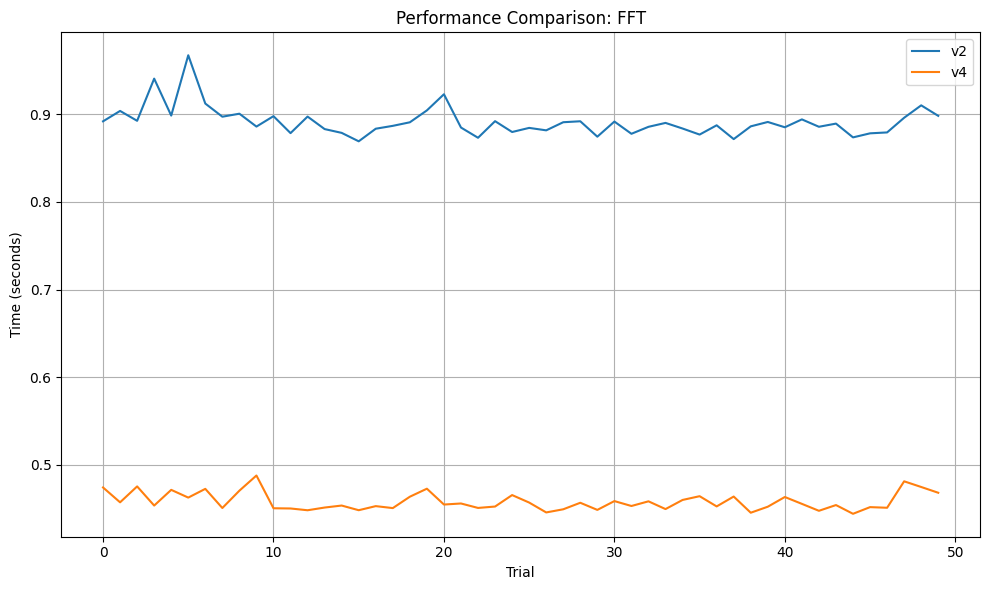

Average time - v2: 0.891397 sec
Average time - v4: 0.458061 sec


In [23]:
import numpy as np
import timeit
import matplotlib.pyplot as plt

img = read_img("cat.jpg")

# Run multiple trials
num_trials = 50
v1 = []
v2 = []
v3 = []
v4 = []

def test_v1():
	kernel_convolution_fft(img, MAT_BOX_BLUR_3)
	kernel_convolution_fft(img, MAT_GAUSS_BLUR_15)
	kernel_convolution_fft(img, MAT_UNSHARP_BLUR_5)

def test_v2():
	kernel_convolution_fft_2(img, MAT_BOX_BLUR_3)
	kernel_convolution_fft_2(img, MAT_GAUSS_BLUR_15)
	kernel_convolution_fft_2(img, MAT_UNSHARP_BLUR_5)

def test_v3():
	kernel_convolution_fft_3(img, MAT_BOX_BLUR_3)
	kernel_convolution_fft_3(img, MAT_GAUSS_BLUR_15)
	kernel_convolution_fft_3(img, MAT_UNSHARP_BLUR_5)

def test_v4():
	kernel_convolution_rfft(img, MAT_BOX_BLUR_3)
	kernel_convolution_rfft(img, MAT_GAUSS_BLUR_15)
	kernel_convolution_rfft(img, MAT_UNSHARP_BLUR_5)

for _ in range(num_trials):
    # t1 = timeit.timeit(test_v1, number=1)
    t2 = timeit.timeit(test_v2, number=1)
    # t3 = timeit.timeit(test_v3, number=1)
    t4 = timeit.timeit(test_v4, number=1)
    # v1.append(t1)
    v2.append(t2)
    # v3.append(t3)
    v4.append(t4)

# Plotting
plt.figure(figsize=(10, 6))
# plt.plot(v1, label='v1')
plt.plot(v2, label='v2')
# plt.plot(v3, label='v3')
plt.plot(v4, label='v4')
plt.xlabel('Trial')
plt.ylabel('Time (seconds)')
plt.title('Performance Comparison: FFT')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary statistics
# print(f"Average time - v1: {np.mean(v1):.6f} sec")
print(f"Average time - v2: {np.mean(v2):.6f} sec")
# print(f"Average time - v3: {np.mean(v3):.6f} sec")
print(f"Average time - v4: {np.mean(v4):.6f} sec")


In [1]:
 def adjust_contrast_no_percentiles(img_2d, contrast_factor=1.0):
	img_2d = np.clip(img_2d, 0, 255)

	normalized = img_2d / 255.0
	normalized -= 0.5
	normalized *= contrast_factor
	normalized += 0.5

	adjusted = np.clip(normalized, 0, 1) * 255
	return adjusted.astype(np.uint8)

def adjust_contrast_with_percentiles(img_2d, contrast_factor=1.0):
	if contrast_factor == 1.0:
		return img_2d
	minval, maxval = np.percentile(img_2d, [2, 98])
	img_2d = np.clip(img_2d, minval, maxval)
	normalized = (img_2d - minval) / (maxval - minval)

	# Adjust contrast
	normalized -= 0.5
	normalized *= contrast_factor
	normalized += 0.5
	# Clip and scale back to [0, 255]
	adjusted = np.clip(normalized, 0, 1) * 255
	return adjusted.astype(np.uint8)

def contrast_method_1(image: np.ndarray, factor: float):
    """Adjust contrast using fixed midpoint (127.5)."""
    mid = 127.5
    new = (image - mid) * factor + mid
    return np.clip(new, 0, 255).astype(np.uint8)

def contrast_method_2(image: np.ndarray, factor: float):
    """Adjust contrast using normalized method (adaptive min/max)."""
    min_val = image.min(axis=(0, 1), keepdims=True)
    max_val = image.max(axis=(0, 1), keepdims=True)

    norm = (image - min_val) / (max_val - min_val + 1e-8)       # Normalize to [0,1]
    adjusted = (norm - 0.5) * factor + 0.5                      # Contrast adjust
    rescaled = adjusted * 255                                  # Back to [0,255]
    return np.clip(rescaled, 0, 255).astype(np.uint8)

def contrast_method_3(image: np.ndarray, factor: float):
    """Adjust contrast using calculated midpoint (mean of pixel values)."""
    mid = image.mean(axis=(0, 1), keepdims=True)  # Per-channel mean
    new = (image - mid) * factor + mid
    return np.clip(new, 0, 255).astype(np.uint8)

NameError: name 'np' is not defined

In [47]:
img = read_img('cat.jpg')
no_percentile_img = adjust_contrast_no_percentiles(img, -2)
percentile_img = adjust_contrast_with_percentiles(img, -2)

save_img(no_percentile_img, 'image/contrast/no_percentile_cat.png')
save_img(percentile_img, 'image/contrast/percentile_cat.png')

In [29]:
import numpy as np
import timeit
import matplotlib.pyplot as plt
from PIL import Image

# Example image read function, assuming you have an 'img' array
img = read_img('cat.jpg')
no_percentile_img = adjust_contrast_no_percentiles(img, 5)
percentile_img = adjust_contrast_with_percentiles(img, 5)

save_img(no_percentile_img, 'image/contrast/no_percentile_cat.png')
save_img(percentile_img, 'image/contrast/percentile_cat.png')

# Define trial counts
num_trials = 100
v1 = []  # adjust_contrast_no_percentiles
v2 = []  # adjust_contrast_with_histogram
v3 = []  # adjust_contrast_with_percentiles

def test_v1():
	adjust_contrast_no_percentiles(img, contrast_factor=5)

def test_v2():
	adjust_contrast_with_histogram(img, contrast_factor=5)

def test_v3():
	adjust_contrast_with_percentiles(img, contrast_factor=5)

for _ in range(num_trials):
	t1 = timeit.timeit(test_v1, number=5)
	# t2 = timeit.timeit(test_v2, number=5)
	t3 = timeit.timeit(test_v3, number=5)

	v1.append(t1)
	# v2.append(t2)
	v3.append(t3)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(v1, label='No Percentiles')
# plt.plot(v2, label='With Histogram')
plt.plot(v3, label='With Percentiles')
plt.xlabel('Trial')
plt.ylabel('Time (seconds)')
plt.title('Contrast Adjustment Benchmark')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary statistics
print(f"Average time - No Percentiles: {np.mean(v1):.6f} sec")
# print(f"Average time - With Histogram: {np.mean(v2):.6f} sec")
print(f"Average time - With Percentiles: {np.mean(v3):.6f} sec")


KeyboardInterrupt: 